# Focusing the field of an array source using the phase conjugation method

The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates a simulation with a spherical section array transducer with 256 elements and demonstrates an implementation of the phase conjugation method to focus through a spherical scatterer

## Import the OptimUS library

Load the OptimUS library.

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
import optimus

## Specify a spherical section array transducer as acoustic source

The OptimUS library provides different predefined wave fields, among which is a spherical section array transducer radiating in 2*pi space. The array requires the frequency, element centroid locations, element radius and velocity, optionally, the source axis, and its location, which is in this case at [-0.18, 0, 0] $\text{m}$. The elements are assumed to be planar circular piston sources. Here, uniform normal velocity of 1 $\text{m s}^{-1}$ is applied to all elements of the array.

The centroids of an example transducer array are stored in a file available in this folder. Alternatively, one can use a custom defined transducer array.

In [3]:
frequency = 300e3
element_radius = 0.003
array_radius_of_curvature = 0.18
centroid_file='Data/default_random_array_centroid_locations.dat'
array_source = optimus.source.create_array(frequency, 
                                           element_radius=element_radius,
                                           centroid_locations_filename=centroid_file,
                                           location=[-array_radius_of_curvature, 0, 0], 
                                           number_of_point_sources_per_wavelength=4, 
                                           velocity=0.5)

## Specify the physical settings for the simulation

Let us consider a spherical object with 10 mm radius that resembles bone and is embedded in an unbounded region of water. This object is meshed with 4 elements per wavelength of the exterior medium.

In [4]:
sphere_radius = 10e-3
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')
ext_wavelength = material_ext.compute_wavelength(frequency)

geometry = optimus.geometry.shapes.Sphere(radius=sphere_radius, 
                                          origin=(-4*sphere_radius, 0, 0), 
                                          element_size=ext_wavelength/3)


## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. Let us use a model with default settings.

In [5]:
model = optimus.model.create_default_model(array_source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

*Warning:* A high frequency with a small mesh size was used for this tutorial. Solving the model can take several minutes.

In [6]:
%%time
model.solve()

CPU times: user 2min 14s, sys: 966 ms, total: 2min 15s
Wall time: 1min 10s


## Visualise the wave field


Let us define a plane on which to evaluate the total wave field, i.e. scattered field + incident field.

In [7]:
import numpy as np
Nx = 101
Ny = 101
xmin, xmax, ymin, ymax = [-array_radius_of_curvature, 0.5*array_radius_of_curvature, 
                          -4*sphere_radius, 4*sphere_radius]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

The calculation of the total field can be computationally expensive, depending on the size of the transducer array and the visualisation grid.

In [8]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(resolution=(Nx, Ny), bounding_box=(xmin, xmax, ymin, ymax))
postprocess_plane.compute_fields()

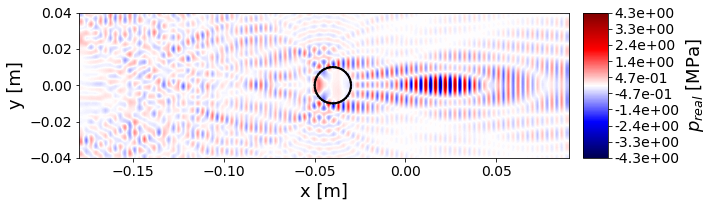

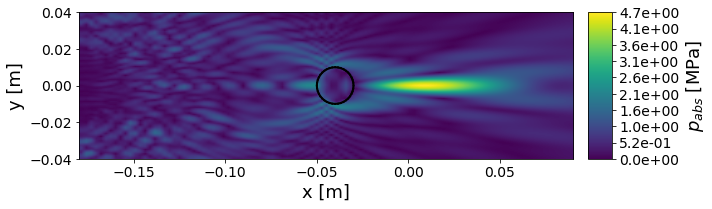

In [9]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total", unit="MPa")

## Focusing through the sphere using phase conjugation



We solve the inverse problem (wave propagating from a point source at the focuse towards the array). First we need to set up a new model with a point source for this purpose.

In [10]:
point_source = optimus.source.create_pointsource(frequency)

In [11]:
inverse_model = optimus.model.create_default_model(point_source, geometry, material_ext, material_int)

The new model must be solved - as before.

*Warning:* A high frequency with a small mesh size was used for this tutorial. Solving the model can take several minutes.

In [12]:
inverse_model.solve()

## Compute the field of the point source on the array elements

Now, we create the default point source at the global origin, where we require the array to focus.

In [13]:
array_source_locations = array_source.centroid_locations 

In [14]:
postprocess_cloud = optimus.postprocess.VisualiseCloudPoints(inverse_model)
postprocess_cloud.create_computational_grid(points=array_source_locations)
postprocess_cloud.compute_fields()

Create a focusing velocity vector based on the conjugate of the averaged pressure over the surface of each element. The vector is normalised so that the maximum velocity amplitude is 1 $\text{m s}^{-1}$.

In [15]:
number_of_points_per_array_element = int(array_source_locations.shape[1] / array_source.number_of_elements)
pressure_on_array = postprocess_cloud.field.total_field.reshape([array_source.number_of_elements, 
                                                                number_of_points_per_array_element])
pressure_mean_conjugate = np.conj(np.mean(pressure_on_array, axis=1))
focusing_vector = pressure_mean_conjugate / np.max(np.abs(pressure_mean_conjugate))

Change in the velocity due to phase correction is given by

In [16]:
velocity_change = array_source.velocity - focusing_vector

variation in the real and imaginary parts are plotted below

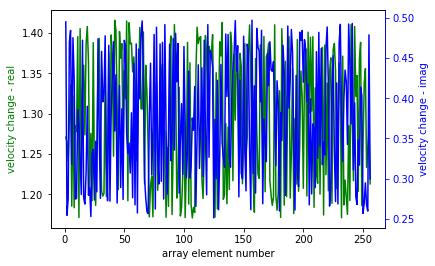

In [17]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(np.arange(1,array_source.number_of_elements+1), velocity_change.real, 'g-')
ax2.plot(np.arange(1,array_source.number_of_elements+1), velocity_change.imag, 'b-')

ax1.set_xlabel('array element number')
ax1.set_ylabel('velocity change - real', color='g')
ax2.set_ylabel('velocity change - imag', color='b')
ax2.spines["right"].set_edgecolor('b')
ax2.tick_params(axis='y', colors='b')

Update velocity vector in array source and resolve the initial model with updated source.

In [18]:
array_source.velocity = focusing_vector
model.source = array_source

Re-solving the model

In [19]:
%%time
model.solve()

CPU times: user 2min 11s, sys: 1.26 s, total: 2min 12s
Wall time: 1min 7s


## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$. We see that the array successfully focuses through the spherical scatterer.

In [20]:
postprocess_plane_updated = optimus.postprocess.VisualisePlane(model)
postprocess_plane_updated.create_computational_grid(resolution=(Nx, Ny), bounding_box=(xmin, xmax, ymin, ymax))
postprocess_plane_updated.compute_fields()

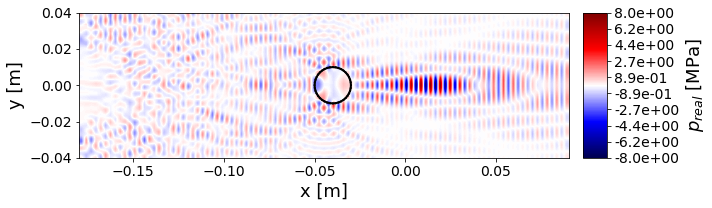

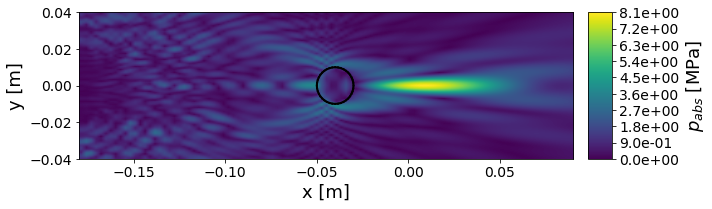

In [21]:
figs_updated = optimus.postprocess.plot_pressure_field(postprocess_plane_updated, field="total", unit="MPa")

The difference in the pressure field due to phase correction is shown below

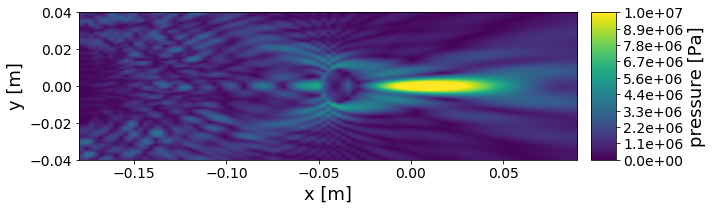

In [22]:
fig = optimus.postprocess.plot.surface_plot(
    np.abs(postprocess_plane.total_field_imshow - postprocess_plane_updated.total_field_imshow),
    axes_lims=(xmin, xmax, ymin, ymax),
    axes_labels=("x [m]","y [m]"),
    colormap="viridis",
    colormap_lims=(0,1e7),
    colorbar_label="pressure [Pa]")